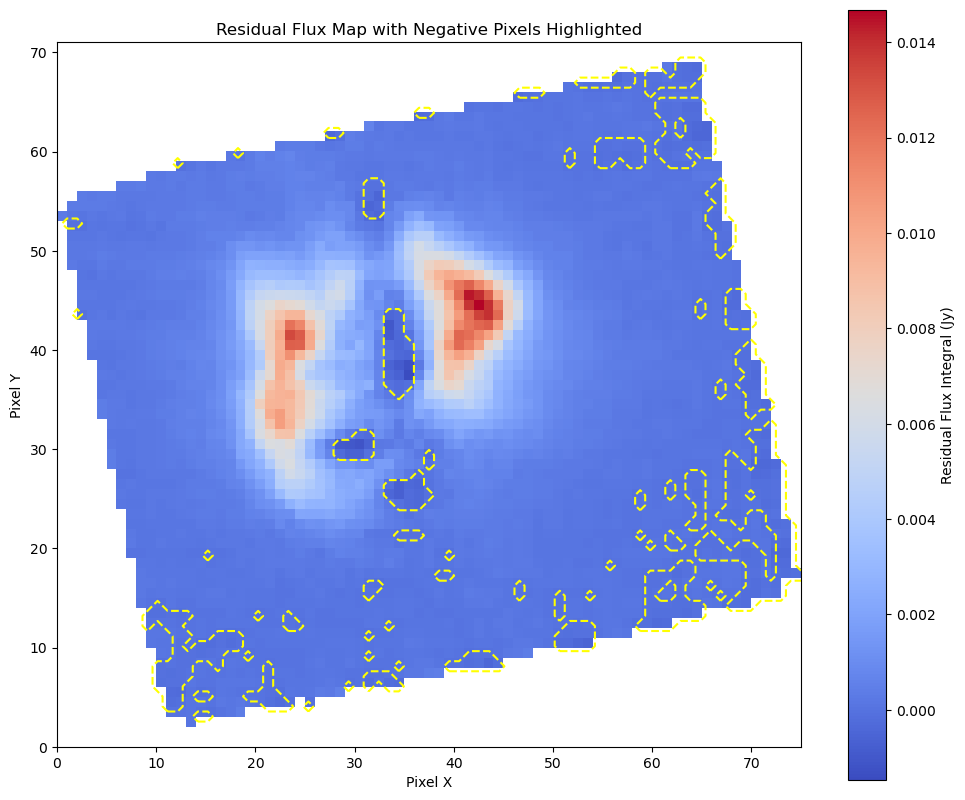

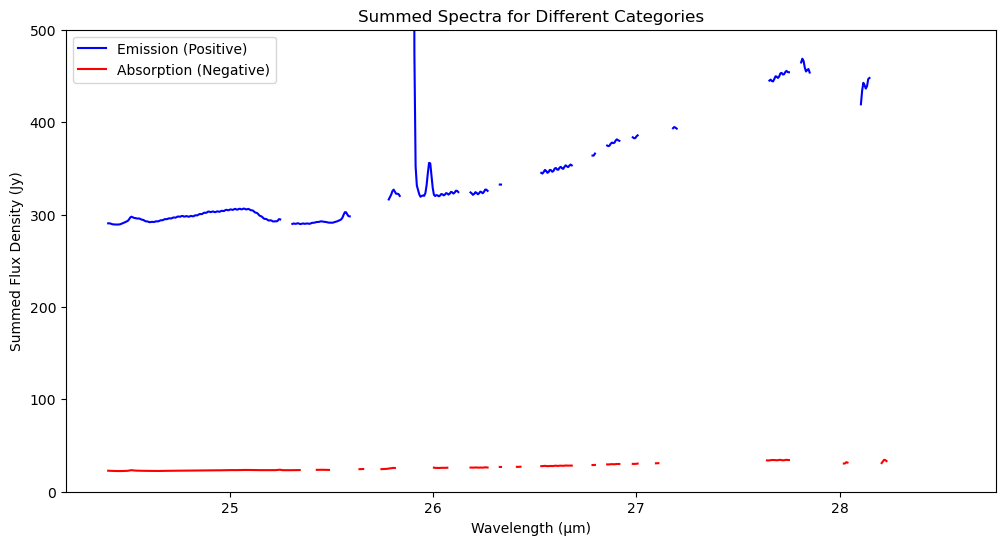

Categorized values saved to 'positive_values.txt' and 'negative_values.txt'.


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Cube
from astropy import units as u
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import warnings

warnings.filterwarnings("ignore")

cube_path = '/Users/mary/Fits image of JWST/ngc6302_ch4-long_s3d.fits'
cube = Cube(cube_path)
cube_data = cube.data
wavelengths = cube.wave.coord()

pixel_size_arcsec = cube.wcs.get_step(unit=u.arcsec)[0]
solid_angle = (pixel_size_arcsec * u.arcsec).to(u.rad)**2
feature_range = (24.60, 25.24)

residual_flux_map = np.full((cube_data.shape[1], cube_data.shape[2]), np.nan)
positive_values = []
negative_values = []
positive_sum_spectrum = np.zeros_like(wavelengths)
negative_sum_spectrum = np.zeros_like(wavelengths)

def interpolate_nan(data):
    nans = np.isnan(data)
    if np.any(nans):
        indices = np.arange(len(data))
        interp = interp1d(indices[~nans], data[~nans], bounds_error=False, fill_value="extrapolate")
        return interp(indices)
    return data

def calculate_feature_flux_integral(flux_density, continuum_line, wavelengths, feature_mask):
    residual_flux = flux_density[feature_mask] - continuum_line[feature_mask]
    feature_wavelengths = wavelengths[feature_mask]
    integral = np.trapz(residual_flux, feature_wavelengths)
    return integral

for y in range(cube_data.shape[1]):
    for x in range(cube_data.shape[2]):
        cube_data[:, y, x] = interpolate_nan(cube_data[:, y, x])

for y in range(cube_data.shape[1]):
    for x in range(cube_data.shape[2]):
        spectrum = cube_data[:, y, x]

        if np.all(np.isnan(spectrum)):
            continue

        flux_density = spectrum * solid_angle.value * 1e6
        smoothed_flux_density = gaussian_filter1d(flux_density, sigma=1)

        left_point = np.argmin(np.abs(wavelengths - feature_range[0]))
        right_point = np.argmin(np.abs(wavelengths - feature_range[1]))
        continuum_line = np.interp(
            wavelengths,
            [wavelengths[left_point], wavelengths[right_point]],
            [smoothed_flux_density[left_point], smoothed_flux_density[right_point]],
        )

        feature_mask = (wavelengths >= feature_range[0]) & (wavelengths <= feature_range[1])
        integral = calculate_feature_flux_integral(smoothed_flux_density, continuum_line, wavelengths, feature_mask)
        residual_flux_map[y, x] = integral

        if integral > 0:
            positive_values.append((x, y, integral))
            positive_sum_spectrum += smoothed_flux_density
        elif integral < 0:
            negative_values.append((x, y, integral))
            negative_sum_spectrum += smoothed_flux_density
negative_value_mask = residual_flux_map < 0

plt.figure(figsize=(12, 10))
plt.imshow(
    residual_flux_map,
    origin="lower",
    cmap="coolwarm",
    extent=(0, cube_data.shape[2], 0, cube_data.shape[1]),
)
plt.colorbar(label="Residual Flux Integral (Jy)")
plt.title("Residual Flux Map with Negative Pixels Highlighted")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.contour(
    negative_value_mask,
    levels=[0.5],
    colors="yellow",
    linewidths=1.5,
    linestyles="--",
    extent=(0, cube_data.shape[2], 0, cube_data.shape[1]),
    label="Negative Pixels"
)

plt.savefig("Residual_Flux_Map_Negative_Highlighted.png", dpi=300)
plt.show()
np.savetxt("25positive_values.txt", positive_values, header="X Y Residual_Flux_Integral (Net Positive)", fmt="%.6f")
np.savetxt("25negative_values.txt", negative_values, header="X Y Residual_Flux_Integral (Net Negative)", fmt="%.6f")


plt.figure(figsize=(12, 6))
plt.plot(wavelengths, positive_sum_spectrum, label="Emission (Positive)", color="blue")
plt.plot(wavelengths, negative_sum_spectrum, label="Absorption (Negative)", color="red")
plt.title("Summed Spectra for Different Categories")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Summed Flux Density (Jy)")
plt.legend()
plt.ylim(0,500)
plt.savefig("25Summed_Spectra_Fixed.png", dpi=300)
plt.show()

print("Categorized values saved to 'positive_values.txt' and 'negative_values.txt'.")
